In [1]:
from helpers import *

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import accuracy_score

from CustomLogisticRegression import CustomLogisticRegression as CLR
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Run Helper

In [2]:
def k_fold_runner(model, dataset, k, target_index):
    accuracy_scores = []

    partition_size = dataset.shape[0] // 3
    starting_index = 0
    for i in range(k):
        dataset_val = dataset[starting_index:partition_size*(i+1), :]
        dataset_train = np.delete(dataset, np.s_[starting_index:partition_size*(i+1)], axis=0)

        features_train = dataset_train[:, :target_index]
        targets_train = dataset_train[:, target_index]

        features_val = dataset_val[:, :target_index]
        targets_val = dataset_val[:, target_index]

        model.fit(features_train, targets_train)

        accuracy_scores.append( evaluate_acc(model.predict(features_val), targets_val) )
        print('itr %d with accuracy %.2f' % (i, accuracy_scores[-1]*100))

        starting_index = partition_size*(i+1)

    print('overall accuracy score of the model = %.2f' % ( (1/len(accuracy_scores))*sum(accuracy_scores)*100 ))


In [3]:
def computeDiscrimination(X_test, prediction, sensitiveAttr):
    X_test = X_test.assign(prediction = prediction)
    protectedGroup = X_test[X_test[sensitiveAttr] == 1]
    unprotectedGroup = X_test[X_test[sensitiveAttr] == 0]
    proportionOfProtected = protectedGroup['prediction'].sum() / protectedGroup[sensitiveAttr].count()
    proportionOfUnprotected = unprotectedGroup['prediction'].sum() / protectedGroup[sensitiveAttr].count()
    discrim = abs(proportionOfProtected - proportionOfUnprotected)
    return discrim

In [4]:
def run(X, y, X_test, y_test, SA):
    kfold = model_selection.KFold(n_splits=5, random_state=7)
    for i, model in enumerate(models):
        cv_result = model_selection.cross_val_score(model, X, y, cv=kfold, scoring='accuracy')

        model.fit(X, y)
        acc_score_val = np.mean(cv_result)

        prediction_test = model.predict(X_test)
        acc_score_test = accuracy_score(y_test, prediction_test)
        discr_score_test = computeDiscrimination(X_test, prediction_test, SA)
        print ('-'*40)
        print ('val: {0}: {1}'.format(names[i], acc_score_val))
        print ('test: {0}: {1}'.format(names[i], acc_score_test))
        print ('test-avg: {0} discrimination: {1}'.format(names[i], discr_score_test))

In [5]:
def run2(X, y, X_test, y_test):
    rs = model_selection.ShuffleSplit(n_splits=5, test_size=.33, random_state=0)
    for i, model in enumerate(models):
        cv_result = model_selection.cross_val_score(model, X, y, cv=rs, scoring='accuracy')

        model.fit(X, y)
        prediction_test = model.predict(X_test)

        acc_score_val = np.mean(cv_result)
        acc_score_test = accuracy_score(y_test, prediction_test)
        print ('-'*40)
        print ('val: {0}: {1}'.format(names[i], acc_score_val))
        print ('test: {0}: {1}'.format(names[i], acc_score_test))

In [6]:
def runAdultWithSplitting(X, y, X_test, y_test, SA):
    X_splits = np.array_split(X, 5)
    y_splits = np.array_split(y, 5)
    
    X_test_splits = np.array_split(X_test, 5)
    y_test_splits = np.array_split(y_test, 5)
    for i, model in enumerate(models):
        acc_val = []
        acc_test = []
        
        disc_val = []
        disc_test = []
        for x_split, y_split, X_test, y_test in zip(X_splits, y_splits, X_test_splits, y_test_splits):
            val_amount = math.floor((1/3) * x_split.shape[0]) # 1/3 of 1 split set
            X_val = x_split[0:val_amount]
            y_val = y_split[0:val_amount]
            X_train = x_split[val_amount:]
            y_train = y_split[val_amount:]
#         splitSize = x_split.shape[0]
#         X_train = x_split[0:splitSize-val_amount]
#         y_train = y_split[0:splitSize-val_amount]
#         X_val = x_split[splitSize-val_amount:]
#         y_val = y_split[splitSize-val_amount:]
            model.fit(X_train, y_train)
            
            prediction_val = model.predict(X_val)
            acc_score_val = np.mean(y_val == prediction_val)
            discr_score_val = computeDiscrimination(X_val, prediction_val, SA)
            acc_val.append(acc_score_val)
            disc_val.append(discr_score_val)
            
            prediction_test = model.predict(X_test)
            acc_score_test = accuracy_score(y_test, prediction_test)
            discr_score_test = computeDiscrimination(X_test, prediction_test, SA)
            acc_test.append(acc_score_test)
            disc_test.append(discr_score_test)
            
            print ('-'*40)
            print ('val: {0}: {1}'.format(names[i], acc_score_val))
            print ('val: {0} discrimination: {1}'.format(names[i], discr_score_val))
            print ('test: {0}: {1}'.format(names[i], acc_score_test))
            print ('test: {0} discrimination: {1}'.format(names[i], discr_score_test))
        print ('-'*40)
        print ('val-avg: {0}: {1}'.format(names[i], np.mean(acc_val)))
        print ('val-avg: {0} discrimination: {1}'.format(names[i], np.mean(disc_val)))
        print ('test-avg: {0}: {1}'.format(names[i], np.mean(acc_test)))
        print ('test-avg: {0} discrimination: {1}'.format(names[i], np.mean(disc_test)))
        print ('-'*80)
        print ('-'*80)

In [34]:
def runGermanWithSplitting(X, y, SA):
#     X, y = shuffle(X, y, random_state=7)
    
    X_splits = np.array_split(X, 5)
    y_splits = np.array_split(y, 5)
    for i, model in enumerate(models):
        acc_val = []
        acc_test = []
        
        disc_val = []
        disc_test = []
        for x_split, y_split in zip(X_splits, y_splits):
            train_amount = math.floor(0.5 * x_split.shape[0]) # 50% of 1 split set (round)
            X_train = x_split[0:train_amount]
            y_train = y_split[0:train_amount]
            val_amount = math.floor(0.2 * x_split.shape[0]) # 20% of 1 split set
            X_val = x_split[train_amount:train_amount+val_amount]
            y_val = y_split[train_amount:train_amount+val_amount]
            X_test = x_split[train_amount+val_amount:] # 30% of 1 split set
            y_test = y_split[train_amount+val_amount:]

            model.fit(X_train, y_train)
            
            prediction_val = model.predict(X_val)
            acc_score_val = np.mean(y_val == prediction_val)
            discr_score_val = computeDiscrimination(X_val, prediction_val, SA)
            acc_val.append(acc_score_val)
            disc_val.append(discr_score_val)
            
            prediction_test = model.predict(X_test)
            acc_score_test = accuracy_score(y_test, prediction_test)
            discr_score_test = computeDiscrimination(X_test, prediction_test, SA)
            acc_test.append(acc_score_test)
            disc_test.append(discr_score_test)
            
            print ('-'*40)
            print ('val: {0}: {1}'.format(names[i], acc_score_val))
            print ('val: {0} discrimination: {1}'.format(names[i], discr_score_val))
            print ('test: {0}: {1}'.format(names[i], acc_score_test))
            print ('test: {0} discrimination: {1}'.format(names[i], discr_score_test))
        print ('-'*40)
        print ('val-avg: {0}: {1}'.format(names[i], np.mean(acc_val)))
        print ('val-avg: {0} discrimination: {1}'.format(names[i], np.mean(disc_val)))
        print ('test-avg: {0}: {1}'.format(names[i], np.mean(acc_test)))
        print ('test-avg: {0} discrimination: {1}'.format(names[i], np.mean(disc_test)))
        print ('-'*80)
        print ('-'*80)

# Models to Run

In [22]:
models = []
#names = ['LR', 
#          'LR-10000', 
#          'Custom Logistic Regression(lr=0.1, max_itr=5)',
#          'Custom Logistic Regression(lr=0.1, max_itr=10)',
#          'Custom Logistic Regression(lr=0.1, max_itr=50)',
#          'Custom Logistic Regression(lr=0.1, max_itr=100)', 
#          'Custom Logistic Regression(lr=0.1, max_itr=500)',
#          'Custom Logistic Regression(lr=0.1, max_itr=1500)',
#          'Custom Logistic Regression(lr=0.1, max_itr=2000)',
#          'Custom Logistic Regression(lr=0.01, max_itr=5)',
#          'Custom Logistic Regression(lr=0.01, max_itr=10)',
#          'Custom Logistic Regression(lr=0.01, max_itr=50)',
#          'Custom Logistic Regression(lr=0.01, max_itr=100)',
#          'Custom Logistic Regression(lr=0.01, max_itr=500)',
#          'Custom Logistic Regression(lr=0.01, max_itr=1500)',
#          'Custom Logistic Regression(lr=0.01, max_itr=2000)',
names = ['Custom Logistic Regression(lr=0.001, max_itr=1)',
         'Custom Logistic Regression(lr=0.001, max_itr=2)',
         'Custom Logistic Regression(lr=0.001, max_itr=3)',
         'Custom Logistic Regression(lr=0.001, max_itr=4)',
         'Custom Logistic Regression(lr=0.001, max_itr=5)',
         'Custom Logistic Regression(lr=0.001, max_itr=10)',
         'Custom Logistic Regression(lr=0.001, max_itr=15)',
         'Custom Logistic Regression(lr=0.001, max_itr=20)',
         'Custom Logistic Regression(lr=0.001, max_itr=25)',
         'Custom Logistic Regression(lr=0.001, max_itr=30)',
         'Custom Logistic Regression(lr=0.001, max_itr=35)',
         'Custom Logistic Regression(lr=0.001, max_itr=40)',
         'Custom Logistic Regression(lr=0.001, max_itr=45)',
         'Custom Logistic Regression(lr=0.001, max_itr=50)',
         'Custom Logistic Regression(lr=0.001, max_itr=100)',
#          'Custom Logistic Regression(lr=0.001, max_itr=500)',
#          'Custom Logistic Regression(lr=0.001, max_itr=1500)',
#          'Custom Logistic Regression(lr=0.001, max_itr=2000)',
#          'Custom Logistic Regression(lr=0.0001, max_itr=5)',
#          'Custom Logistic Regression(lr=0.0001, max_itr=10)',
#          'Custom Logistic Regression(lr=0.0001, max_itr=50)',
#          'Custom Logistic Regression(lr=0.0001, max_itr=100)',
#          'Custom Logistic Regression(lr=0.0001, max_itr=500)',
#          'Custom Logistic Regression(lr=0.0001, max_itr=1500)',
#          'Custom Logistic Regression(lr=0.0001, max_itr=2000)'
        ]

# models.append(LogisticRegression(solver='lbfgs', max_iter=1000))
# models.append(LogisticRegression(solver='lbfgs', fit_intercept=False, max_iter=10000, penalty='none', C=1e10))
# models.append(CLR(0.1, 5))
# models.append(CLR(0.1, 10))
# models.append(CLR(0.1, 50))
# models.append(CLR(0.1, 100))
# models.append(CLR(0.1, 500))
# models.append(CLR(0.1, 1500))
# models.append(CLR(0.1, 2000))
# models.append(CLR(0.01, 5))
# models.append(CLR(0.01, 10))
# models.append(CLR(0.01, 50))
# models.append(CLR(0.01, 100))
# models.append(CLR(0.01, 500))
# models.append(CLR(0.01, 1500))
# models.append(CLR(0.01, 2000))
models.append(CLR(0.001, 1))
models.append(CLR(0.001, 2))
models.append(CLR(0.001, 3))
models.append(CLR(0.001, 4))
models.append(CLR(0.001, 5))
models.append(CLR(0.001, 10))
models.append(CLR(0.001, 15))
models.append(CLR(0.001, 20))
models.append(CLR(0.001, 25))
models.append(CLR(0.001, 30))
models.append(CLR(0.001, 35))
models.append(CLR(0.001, 40))
models.append(CLR(0.001, 45))
models.append(CLR(0.001, 50))
models.append(CLR(0.001, 100))
# models.append(CLR(0.001, 500))
# models.append(CLR(0.001, 1500))
# models.append(CLR(0.001, 2000))
# models.append(CLR(0.0001, 5))
# models.append(CLR(0.0001, 10))
# models.append(CLR(0.0001, 50))
# models.append(CLR(0.0001, 100))
# models.append(CLR(0.0001, 500))
# models.append(CLR(0.0001, 1500))
# models.append(CLR(0.0001, 2000))

# Adult Dataset

In [23]:
df_adult, pct = load_adult('datasets/adult/adult.data')
X_adult = df_adult.iloc[:, :-1]
y_adult = df_adult.iloc[:, -1]
print('percentage of corrupt rows in training: {0:.1f}%'.format((1-pct)*100))

df_adult_test, pct = load_adult('datasets/adult/adult.test')
X_adult_test = df_adult_test.iloc[:, :-1]
y_adult_test = df_adult_test.iloc[:, -1]
print('percentage of corrupt rows in testing: {0:.1f}%'.format((1-pct)*100))

percentage of corrupt rows in training: 7.4%
percentage of corrupt rows in testing: 7.5%


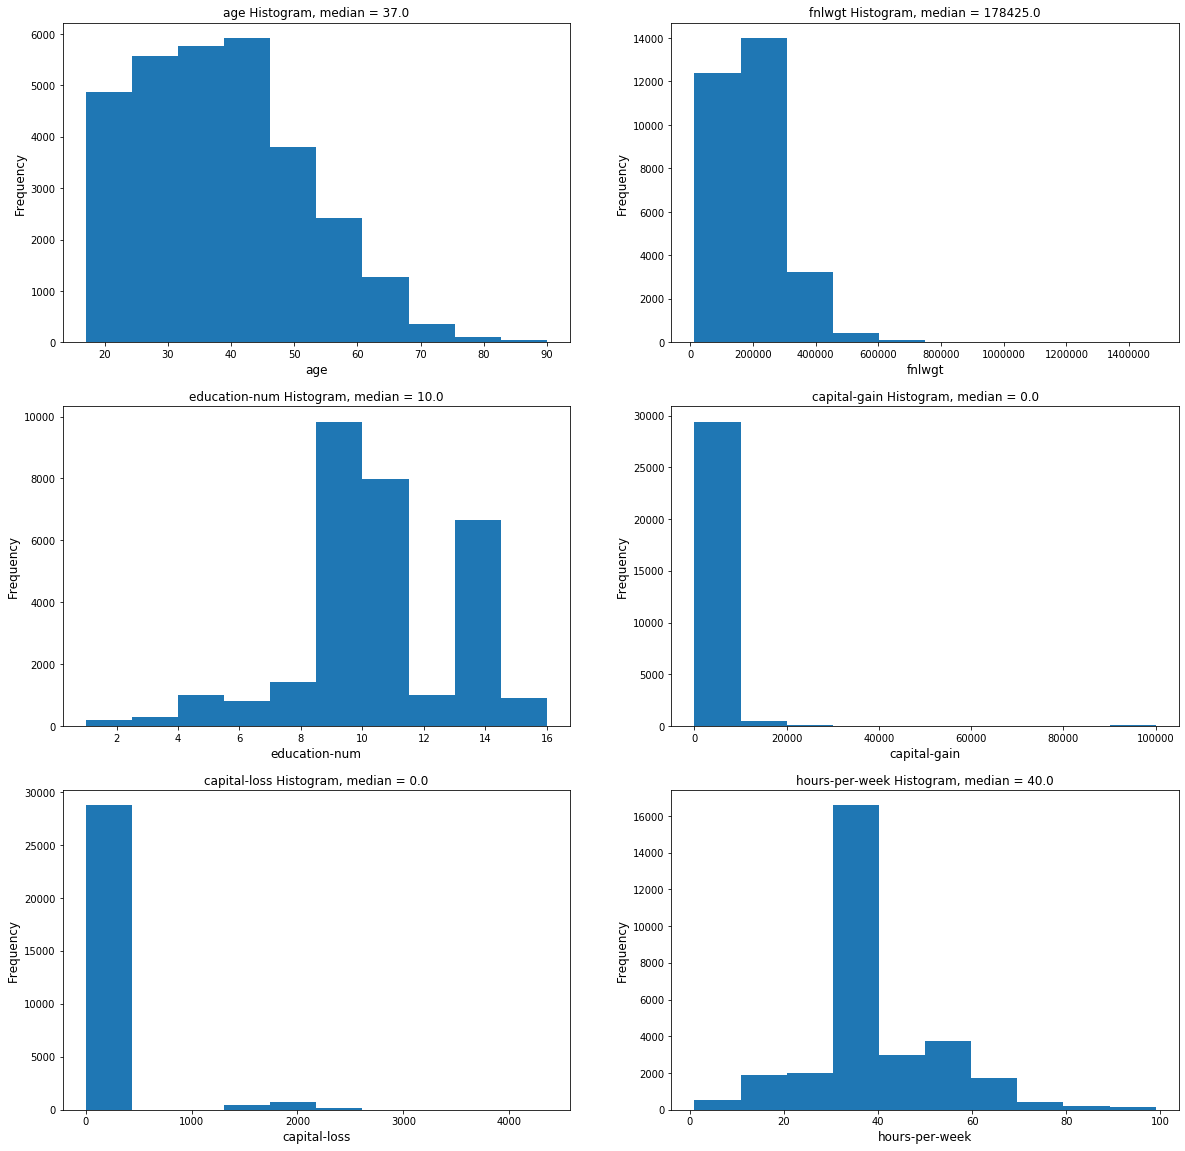

In [24]:
cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
fig, ax = plt.subplots(3, 2, figsize=(20, 20))
ax = ax.ravel()
for i, col in enumerate(cols):
    ax[i].hist(X_adult[col])
    median = X_adult[col].median()
    ax[i].set_title('{} Histogram, median = {}'.format(col, median), fontsize=12)
    ax[i].set_xlabel(col, fontsize=12)
    ax[i].set_ylabel('Frequency', fontsize=12)
# fig.savefig('2-quantiles-2.png')

# expanding (one-hot encoding)

In [25]:
# X_adult['sex'] = X_adult['sex'].map({'Female': 1, 'Male': 0}).astype(int)
# X_adult_test['sex'] = X_adult_test['sex'].map({'Female': 1, 'Male': 0}).astype(int)

X_adult, X_adult_test = encode_adult(X_adult, X_adult_test)

X_adult_all = X_adult.append(X_adult_test)
X_adult_all_expand = pd.get_dummies(X_adult_all)

# X_expand, X_expand_test = encode_adult(X_expand, X_expand_test)
X_adult_expand = X_adult_all_expand[0:X_adult.shape[0]]
X_adult_expand_test = X_adult_all_expand[X_adult.shape[0]:]

In [26]:
X_adult_expand.head()

,age,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,1,0,1,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,1,0,0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,1,1,0,0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0,1,1,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [27]:
X_adult_expand_test.head()

,age,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0,1,0,0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0,1,1,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,1,0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
5,0,1,0,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [28]:
# run(X_adult_expand, y_adult, X_adult_expand_test, y_adult_test, 'sex')
runAdultWithSplitting(X_adult_expand, y_adult, X_adult_expand_test, y_adult_test, 'sex')

----------------------------------------
val: Custom Logistic Regression(lr=0.001, max_itr=1): 0.7419194430631526
val: Custom Logistic Regression(lr=0.001, max_itr=1) discrimination: 0.0
test: Custom Logistic Regression(lr=0.001, max_itr=1): 0.7533200531208499
test: Custom Logistic Regression(lr=0.001, max_itr=1) discrimination: 0.0
----------------------------------------
val: Custom Logistic Regression(lr=0.001, max_itr=1): 0.7652909000497266
val: Custom Logistic Regression(lr=0.001, max_itr=1) discrimination: 0.0
test: Custom Logistic Regression(lr=0.001, max_itr=1): 0.7533200531208499
test: Custom Logistic Regression(lr=0.001, max_itr=1) discrimination: 0.0
----------------------------------------
val: Custom Logistic Regression(lr=0.001, max_itr=1): 0.7542288557213931
val: Custom Logistic Regression(lr=0.001, max_itr=1) discrimination: 0.0
test: Custom Logistic Regression(lr=0.001, max_itr=1): 0.7576361221779548
test: Custom Logistic Regression(lr=0.001, max_itr=1) discrimination:

----------------------------------------
val: Custom Logistic Regression(lr=0.001, max_itr=5): 0.8070611636001989
val: Custom Logistic Regression(lr=0.001, max_itr=5) discrimination: 0.49443561208267084
test: Custom Logistic Regression(lr=0.001, max_itr=5): 0.8011288180610889
test: Custom Logistic Regression(lr=0.001, max_itr=5) discrimination: 0.488659793814433
----------------------------------------
val: Custom Logistic Regression(lr=0.001, max_itr=5): 0.808055693684734
val: Custom Logistic Regression(lr=0.001, max_itr=5) discrimination: 0.6102189781021897
test: Custom Logistic Regression(lr=0.001, max_itr=5): 0.8081009296148738
test: Custom Logistic Regression(lr=0.001, max_itr=5) discrimination: 0.6383186705767351
----------------------------------------
val: Custom Logistic Regression(lr=0.001, max_itr=5): 0.8009950248756219
val: Custom Logistic Regression(lr=0.001, max_itr=5) discrimination: 0.25
test: Custom Logistic Regression(lr=0.001, max_itr=5): 0.7895086321381142
test: Cus

----------------------------------------
val: Custom Logistic Regression(lr=0.001, max_itr=20): 0.753731343283582
val: Custom Logistic Regression(lr=0.001, max_itr=20) discrimination: 0.013761467889908258
test: Custom Logistic Regression(lr=0.001, max_itr=20): 0.7470119521912351
test: Custom Logistic Regression(lr=0.001, max_itr=20) discrimination: 0.005040322580645161
----------------------------------------
val-avg: Custom Logistic Regression(lr=0.001, max_itr=20): 0.7381580907001541
val-avg: Custom Logistic Regression(lr=0.001, max_itr=20) discrimination: 0.24203051847048712
test-avg: Custom Logistic Regression(lr=0.001, max_itr=20): 0.7391102257636122
test-avg: Custom Logistic Regression(lr=0.001, max_itr=20) discrimination: 0.24592389505379356
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
----------------------------------------
val: Custom Logistic Regression(lr=0.0

----------------------------------------
val: Custom Logistic Regression(lr=0.001, max_itr=40): 0.7248756218905472
val: Custom Logistic Regression(lr=0.001, max_itr=40) discrimination: 1.0346385542168675
test: Custom Logistic Regression(lr=0.001, max_itr=40): 0.7241035856573705
test: Custom Logistic Regression(lr=0.001, max_itr=40) discrimination: 1.0383817427385893
----------------------------------------
val: Custom Logistic Regression(lr=0.001, max_itr=40): 0.7691542288557214
val: Custom Logistic Regression(lr=0.001, max_itr=40) discrimination: 0.08116385911179173
test: Custom Logistic Regression(lr=0.001, max_itr=40): 0.7729083665338645
test: Custom Logistic Regression(lr=0.001, max_itr=40) discrimination: 0.06742738589211618
----------------------------------------
val: Custom Logistic Regression(lr=0.001, max_itr=40): 0.7776119402985074
val: Custom Logistic Regression(lr=0.001, max_itr=40) discrimination: 0.09633027522935779
test: Custom Logistic Regression(lr=0.001, max_itr=40):

# LabelEncoder

In [ ]:
# encoders = {"workclass": preprocessing.LabelEncoder(), 
#             "education": preprocessing.LabelEncoder(), 
#             "marital-status": preprocessing.LabelEncoder(), 
#             "occupation": preprocessing.LabelEncoder(), 
#             "relationship": preprocessing.LabelEncoder(), 
#             "race": preprocessing.LabelEncoder(), 
#             "native-country": preprocessing.LabelEncoder()}

# X_encoded = encode(X_adult, encoders)
# X_encoded_test = encode(X_adult_test, encoders)

In [ ]:
# run(X_encoded, y_adult, X_encoded_test, y_adult_test)

# German Dataset

In [29]:
# load german dataset
df_german = load_german('datasets/german/german.data')
X_german = df_german.iloc[:, :-1]
y_german = df_german.iloc[:, -1]

# X_german, X_german_test, y_german, y_german_test = train_test_split(X_german, y_german, test_size=0.3, random_state=0)

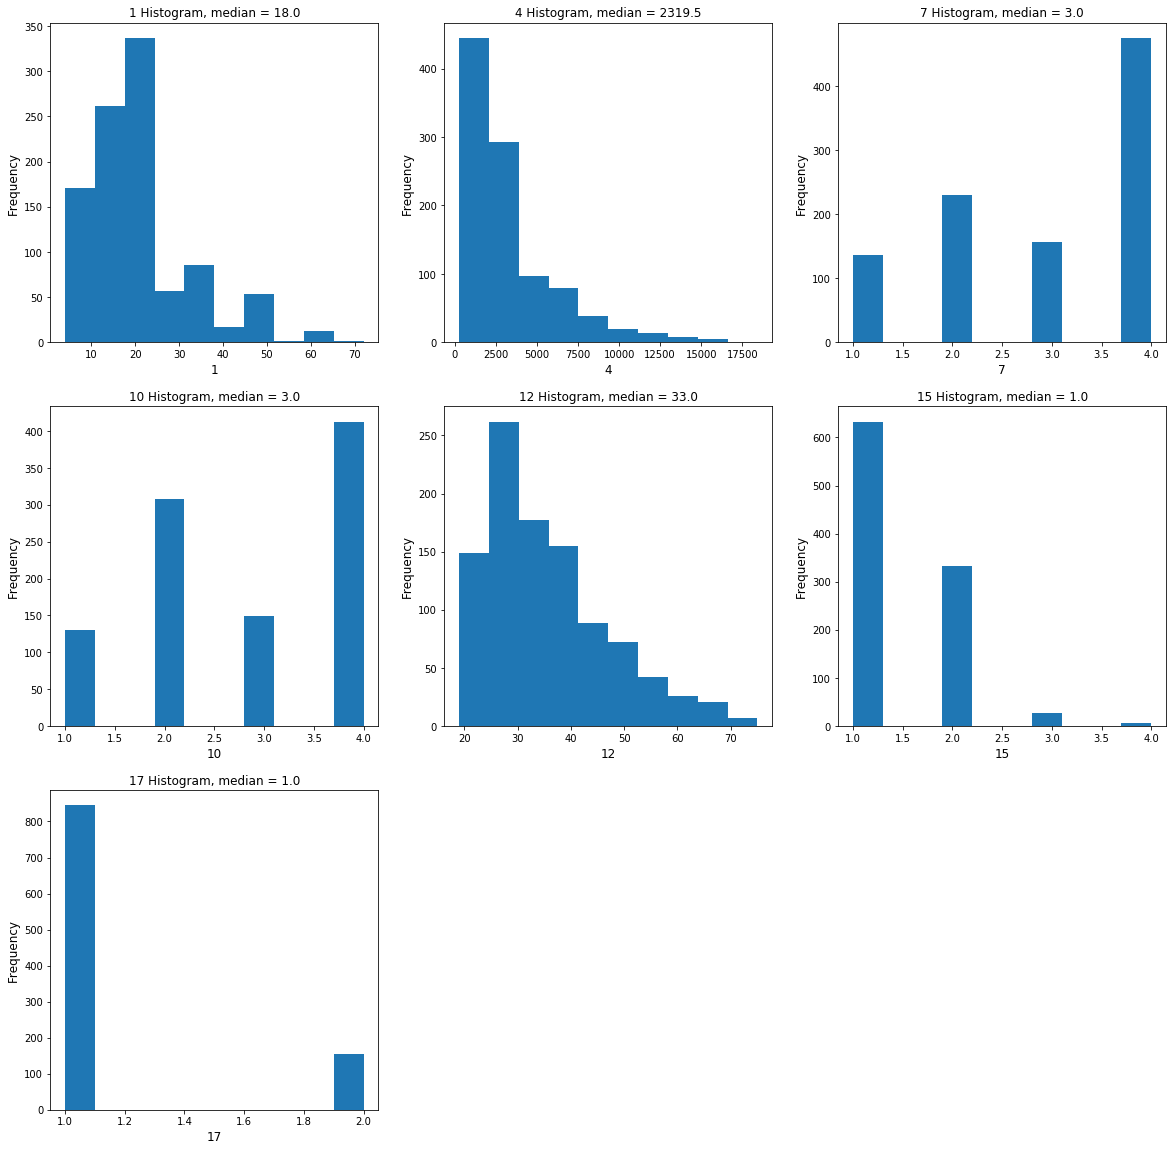

In [30]:
cols = [1, 4, 7, 10, 12, 15, 17]
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
ax = ax.ravel()
for i, col in enumerate(cols):
    ax[i].hist(X_german[col])
    median = X_german[col].median()
    ax[i].set_title('{} Histogram, median = {}'.format(col, median), fontsize=12)
    ax[i].set_xlabel(col, fontsize=12)
    ax[i].set_ylabel('Frequency', fontsize=12)
fig.delaxes(ax[7])
fig.delaxes(ax[8])
# fig.savefig('2-quantiles-2.png')

# expanding (one-hot encoding)

In [31]:
# X_german, X_german_test = encode_german(X_german, X_german_test)

# X_german_all = X_german.append(X_german_test)
# X_german_all_expand = pd.get_dummies(X_german_all)

# # X_expand, X_expand_test = encode_adult(X_expand, X_expand_test)
# X_german_expand = X_german_all_expand[0:X_german.shape[0]]
# X_german_expand_test = X_german_all_expand[X_german.shape[0]:]

X_german = encode_german_all(X_german)
X_german_expand = pd.get_dummies(X_german)

In [32]:
X_german_expand.head()

,1,4,7,10,12,15,17,0_A11,0_A12,0_A13,...,14_A152,14_A153,16_A171,16_A172,16_A173,16_A174,18_A191,18_A192,19_A201,19_A202
0,0,0,1,1,1,1,1,1,0,0,...,1,0,0,0,1,0,0,1,1,0
1,1,1,0,0,1,1,1,0,1,0,...,1,0,0,0,1,0,1,0,1,0
2,0,0,0,1,1,1,1,0,0,0,...,1,0,0,1,0,0,1,0,1,0
3,1,1,0,1,1,1,1,1,0,0,...,0,1,0,0,1,0,1,0,1,0
4,1,1,1,1,1,1,1,1,0,0,...,0,1,0,0,1,0,1,0,1,0


In [35]:
runGermanWithSplitting(X_german_expand, y_german, 12)

----------------------------------------
val: Custom Logistic Regression(lr=0.001, max_itr=1): 0.725
val: Custom Logistic Regression(lr=0.001, max_itr=1) discrimination: 0.0
test: Custom Logistic Regression(lr=0.001, max_itr=1): 0.65
test: Custom Logistic Regression(lr=0.001, max_itr=1) discrimination: 0.0
----------------------------------------
val: Custom Logistic Regression(lr=0.001, max_itr=1): 0.625
val: Custom Logistic Regression(lr=0.001, max_itr=1) discrimination: 0.0
test: Custom Logistic Regression(lr=0.001, max_itr=1): 0.7833333333333333
test: Custom Logistic Regression(lr=0.001, max_itr=1) discrimination: 0.0
----------------------------------------
val: Custom Logistic Regression(lr=0.001, max_itr=1): 0.675
val: Custom Logistic Regression(lr=0.001, max_itr=1) discrimination: 0.0
test: Custom Logistic Regression(lr=0.001, max_itr=1): 0.5333333333333333
test: Custom Logistic Regression(lr=0.001, max_itr=1) discrimination: 0.0
----------------------------------------
val: Cu

----------------------------------------
val: Custom Logistic Regression(lr=0.001, max_itr=10): 0.675
val: Custom Logistic Regression(lr=0.001, max_itr=10) discrimination: 0.0
test: Custom Logistic Regression(lr=0.001, max_itr=10): 0.5333333333333333
test: Custom Logistic Regression(lr=0.001, max_itr=10) discrimination: 0.0
----------------------------------------
val: Custom Logistic Regression(lr=0.001, max_itr=10): 0.625
val: Custom Logistic Regression(lr=0.001, max_itr=10) discrimination: 0.0
test: Custom Logistic Regression(lr=0.001, max_itr=10): 0.7166666666666667
test: Custom Logistic Regression(lr=0.001, max_itr=10) discrimination: 0.0
----------------------------------------
val: Custom Logistic Regression(lr=0.001, max_itr=10): 0.625
val: Custom Logistic Regression(lr=0.001, max_itr=10) discrimination: 0.0
test: Custom Logistic Regression(lr=0.001, max_itr=10): 0.7166666666666667
test: Custom Logistic Regression(lr=0.001, max_itr=10) discrimination: 0.0
----------------------

----------------------------------------
val: Custom Logistic Regression(lr=0.001, max_itr=35): 0.625
val: Custom Logistic Regression(lr=0.001, max_itr=35) discrimination: 0.0
test: Custom Logistic Regression(lr=0.001, max_itr=35): 0.7333333333333333
test: Custom Logistic Regression(lr=0.001, max_itr=35) discrimination: 0.016666666666666666
----------------------------------------
val: Custom Logistic Regression(lr=0.001, max_itr=35): 0.625
val: Custom Logistic Regression(lr=0.001, max_itr=35) discrimination: 0.0
test: Custom Logistic Regression(lr=0.001, max_itr=35): 0.7166666666666667
test: Custom Logistic Regression(lr=0.001, max_itr=35) discrimination: 0.0
----------------------------------------
val-avg: Custom Logistic Regression(lr=0.001, max_itr=35): 0.655
val-avg: Custom Logistic Regression(lr=0.001, max_itr=35) discrimination: 0.0
test-avg: Custom Logistic Regression(lr=0.001, max_itr=35): 0.6833333333333333
test-avg: Custom Logistic Regression(lr=0.001, max_itr=35) discrimin

----------------------------------------
val: Custom Logistic Regression(lr=0.001, max_itr=100): 0.725
val: Custom Logistic Regression(lr=0.001, max_itr=100) discrimination: 0.15
test: Custom Logistic Regression(lr=0.001, max_itr=100): 0.8
test: Custom Logistic Regression(lr=0.001, max_itr=100) discrimination: 0.11666666666666667
----------------------------------------
val-avg: Custom Logistic Regression(lr=0.001, max_itr=100): 0.7
val-avg: Custom Logistic Regression(lr=0.001, max_itr=100) discrimination: 0.085
test-avg: Custom Logistic Regression(lr=0.001, max_itr=100): 0.71
test-avg: Custom Logistic Regression(lr=0.001, max_itr=100) discrimination: 0.07666666666666669
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


# Discrimination

In [ ]:
# SA = 'Age'
# s = 'Young'
# positive = 0

# X_german_s = X_german.copy()
# X_german_s[X_german_s['Age'] <= 25] = 1 # protected
# X_german_s[X_german_s['Age'] > 25] = 0 # not protected

# conf_aged = 0
# conf_young = 0
# for index, p in enumerate(y_german):
#     if p == positive:
#         if X_german_s.loc[index, 'Age'] == 0:
#             conf_aged += 1
#         else: # X_german_s.loc[index, 'Age'] == 1 (i.e. protected)
#             conf_young += 1

# conf_aged /= len(X_german_s[X_german_s['Age'] == 0])
# conf_young /= len(X_german_s[X_german_s['Age'] == 1])
# print(conf_aged, conf_young)
# print('DISC = {0:.4f}'.format(conf_aged - conf_young))

In [ ]:
# SA = 'Age'
# s = 'Young'
# positive = 0

# X_german_s = X_german.copy()
# X_german_s[X_german_s['Age'] <= 25] = 1 # protected
# X_german_s[X_german_s['Age'] > 25] = 0 # not protected

# X_train, X_test, y_train, y_test = train_test_split(X_german_s, y_german, test_size=0.3, random_state=42)

# lr = LogisticRegression()
# lr.fit(X_train, y_train)
# pred = lr.predict(X_test)

# conf_aged = 0
# conf_young = 0
# for index, p in enumerate(pred):
#     if p == positive:
#         if X_german_s.loc[index, 'Age'] == 0:
#             conf_aged += 1
#         else: # X_german_s.loc[index, 'Age'] == 1 (i.e. protected)
#             conf_young += 1

# conf_aged /= len(X_german_s[X_german_s['Age'] == 0])
# conf_young /= len(X_german_s[X_german_s['Age'] == 1])
# print(conf_aged, conf_young)
# print('DISC = {0:.4f}'.format(conf_aged - conf_young))

In [ ]:
sss = model_selection.StratifiedShuffleSplit(n_splits=5)
sss.get_n_splits(X_adult_expand, y_adult)
for train_index, test_index in sss.split(X_adult_expand, y_adult):
    print(train_index, test_index)